# Startup

In [1]:
######################
# LIBRARIES DOWNLOAD #
######################

install_packages = False
if install_packages:
    %pip install pandas tqdm numpy matplotlib pyspark dask

In [22]:
####################
# LIBRARIES IMPORT #
####################

import pandas as pd
from tqdm.notebook import tqdm
import numpy as np
import matplotlib.pyplot as plt
import dask.dataframe as dd
import re

In [3]:
#####################
# GLOBAL PARAMETERS #
#####################

chunk_size = 100000 # 10000

authors_path = r"datasets/lighter_authors.json"
books_path = r"datasets/lighter_books.json"
list_path = r"datasets/list.json"
series_path = r"datasets/series.json"

# Loading the data into Pandas' Dataframe

The dataset provided is composed of a "lighter_authors.json" file of about 0.5 Gbs and a "lighter_books.json" file of about 15 Gbs. Considering that where will be a data-type conversion the dataset will become even bigger when loaded on pandas and they could not work on machines with limited amounts of RAM. We can approach this problem from two sides:
* Divide the dataset in chunks, work one chunk at a time and merge the result.
* For every request we could extract only the columns we are interested with.

<!-- Both this approach are slow, we have to load every part of the dataset from the storage and load it on RAM for every exercise, and this increase considerably the amount of time to execute each query. Instead we try to load everything all at once, making the dataset lighter by removing columns useless for our analysis and where possible changing the data-type of useful columns to lighter versions. -->

## Authors dataset

In [4]:
# load the dataset from the .json file to a pandas dataframe
authors = pd.read_json(authors_path, lines = True)

In [5]:
# check the first lines of the dataframe
authors.head()

,ratings_count,average_rating,text_reviews_count,work_ids,book_ids,works_count,id,name,gender,image_url,about,fans_count
0,2862064,4.19,62681,"[3078186, 135328, 1877624, 74123, 3078120, 104...","[386162, 13, 8695, 8694, 6091075, 365, 569429,...",106,4,Douglas Adams,male,https://images.gr-assets.com/authors/159137433...,"Douglas Noël Adams was an English author, comi...",19826
1,1417316,4.02,84176,"[613469, 2305997, 940892, 2611786, 7800569, 31...","[9791, 21, 28, 24, 7507825, 27, 10538, 25, 26,...",75,7,Bill Bryson,male,https://images.gr-assets.com/authors/157859752...,"William McGuire ""Bill"" Bryson, OBE, FRS was bo...",16144
2,56159,4.53,352,"[17150, 808427, 20487307, 90550, 25460625, 171...","[349254, 15222, 14833682, 15221, 18126815, 152...",14,10,Jude Fisher,female,https://images.gr-assets.com/authors/141145711...,"Jude Fisher is the pseudonym for <a href=""http...",60
3,3302,3.79,480,"[4417, 14300808, 14780, 3796968, 44703121, 103...","[40, 9416484, 12482, 3753106, 26889789, 104764...",45,12,James Hamilton-Paterson,male,https://images.gr-assets.com/authors/127051738...,James Hamilton-Paterson's work has been transl...,72
4,7979,3.60,772,"[13330815, 19109351, 42306244, 72694240, 26291...","[8466327, 15739968, 22756778, 51026133, 260451...",61,14,Mark Watson,male,https://images.gr-assets.com/authors/133175379...,Mark Andrew Watson (born 13 February 1980) is ...,179


In [6]:
# check some infos about each column
authors.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 351767 entries, 0 to 351766
Data columns (total 12 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   ratings_count       351767 non-null  int64  
 1   average_rating      351767 non-null  float64
 2   text_reviews_count  351767 non-null  int64  
 3   work_ids            351767 non-null  object 
 4   book_ids            351767 non-null  object 
 5   works_count         351767 non-null  int64  
 6   id                  351767 non-null  int64  
 7   name                351767 non-null  object 
 8   gender              351767 non-null  object 
 9   image_url           351767 non-null  object 
 10  about               351767 non-null  object 
 11  fans_count          351767 non-null  int64  
dtypes: float64(1), int64(5), object(6)
memory usage: 32.2+ MB


In [7]:
# check some infos about the RAM usage of every column
raw_authors_memory_usage = authors.memory_usage(index = True, deep = True)
raw_authors_memory_usage

Index                       132
ratings_count           2814136
average_rating          2814136
text_reviews_count      2814136
work_ids               74732848
book_ids               74732848
works_count             2814136
id                      2814136
name                   26225127
gender                 21473021
image_url              44826054
about                 410897820
fans_count              2814136
dtype: int64

In [8]:
print("The dataset just as imported uses", round(raw_authors_memory_usage.sum() / 1073741824, 2), "GBs of RAM!")
print("The 'about' column covers", round(raw_authors_memory_usage["about"] / raw_authors_memory_usage.sum(), 2) * 100, "% of the total RAM usage alone!")

The dataset just as imported uses 0.62 GBs of RAM!
The 'about' column covers 61.0 % of the total RAM usage alone!


The columns "image_url" and "about" are useless for our analysis so they can be removed.

In [9]:
# remove the useless columns
authors.drop(columns = ["image_url", "about"], inplace = True)
print("The dataset now uses", round(authors.memory_usage(index = True, deep = True).sum() / 1073741824, 2), "GBs of RAM!")

The dataset now uses 0.2 GBs of RAM!


[TODO] CHANGE DATA TYPES?

## Books

The books dataset is much bigger than the authors one and we can't work with it in one go, we have to separate it in chunks. Firstly we analyze what can be done with it by only observing some rows

In [10]:
# load a chunk of the dataset from the .json file to a pandas dataframe
books = pd.read_json(books_path, lines = True, nrows = 10000)

In [11]:
# check the first lines of the chunk
books.head()

,id,title,authors,author_name,author_id,work_id,isbn,isbn13,asin,language,...,format,edition_information,image_url,publisher,num_pages,series_id,series_name,series_position,shelves,description
0,2,Harry Potter and the Order of the Phoenix (Har...,"[{'id': '1077326', 'name': 'J.K. Rowling', 'ro...",J.K. Rowling,1077326,2809203,0439358078,9780439358071,,eng,...,Paperback,US Edition,https://i.gr-assets.com/images/S/compressed.ph...,Scholastic Inc.,870,45175,Harry Potter,5,"[{'name': 'to-read', 'count': 324191}, {'name'...",There is a door at the end of a silent corrido...
1,3,Harry Potter and the Sorcerer's Stone (Harry P...,"[{'id': '1077326', 'name': 'J.K. Rowling', 'ro...",J.K. Rowling,1077326,4640799,,,,eng,...,Hardcover,Library Edition,https://i.gr-assets.com/images/S/compressed.ph...,Scholastic Inc,309,45175,Harry Potter,1,"[{'name': 'fantasy', 'count': 63540}, {'name':...",Harry Potter's life is miserable. His parents ...
2,4,Harry Potter and the Chamber of Secrets (Harry...,None,J.K. Rowling,1077326,6231171,0439554896,9780439554893,,eng,...,Hardcover,,https://i.gr-assets.com/images/S/compressed.ph...,Scholastic,352,45175,Harry Potter,2,"[{'name': 'to-read', 'count': 282341}, {'name'...",The Dursleys were so mean and hideous that sum...
3,5,Harry Potter and the Prisoner of Azkaban (Harr...,"[{'id': '1077326', 'name': 'J.K. Rowling', 'ro...",J.K. Rowling,1077326,2402163,043965548X,9780439655484,,eng,...,Mass Market Paperback,,https://i.gr-assets.com/images/S/compressed.ph...,Scholastic Inc.,435,45175,Harry Potter,3,"[{'name': 'to-read', 'count': 292815}, {'name'...","For twelve long years, the dread fortress of A..."
4,6,Harry Potter and the Goblet of Fire (Harry Pot...,"[{'id': '1077326', 'name': 'J.K. Rowling', 'ro...",J.K. Rowling,1077326,3046572,,,,eng,...,Paperback,First Scholastic Trade Paperback Edition,https://i.gr-assets.com/images/S/compressed.ph...,Scholastic,734,45175,Harry Potter,4,"[{'name': 'to-read', 'count': 287086}, {'name'...",Harry Potter is midway through his training as...


In [12]:
# check some infos about each column
books.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9999 entries, 0 to 9998
Data columns (total 26 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   id                         9999 non-null   int64  
 1   title                      9999 non-null   object 
 2   authors                    3742 non-null   object 
 3   author_name                9999 non-null   object 
 4   author_id                  9999 non-null   int64  
 5   work_id                    9999 non-null   int64  
 6   isbn                       9999 non-null   object 
 7   isbn13                     9999 non-null   object 
 8   asin                       9999 non-null   object 
 9   language                   9999 non-null   object 
 10  average_rating             9999 non-null   float64
 11  rating_dist                9999 non-null   object 
 12  ratings_count              9999 non-null   int64  
 13  text_reviews_count         9999 non-null   int64

In [13]:
# check some infos about the RAM usage of every column
raw_books_memory_usage = books.memory_usage(index = True, deep = True)
raw_books_memory_usage

Index                             132
id                              79992
title                          929445
authors                        455800
author_name                    713677
author_id                       79992
work_id                         79992
isbn                           667641
isbn13                         697223
asin                           589989
language                       596758
average_rating                  79992
rating_dist                    972520
ratings_count                   79992
text_reviews_count              79992
publication_date               654329
original_publication_date      638162
format                         655109
edition_information            610372
image_url                     1484359
publisher                      710464
num_pages                      401847
series_id                      598856
series_name                    634022
series_position                588928
shelves                       5910832
description 

In [14]:
print("The dataset just as imported uses", round(raw_books_memory_usage.sum() / 1073741824, 2), "GBs of RAM!")
print("The 'about' column covers", round(raw_books_memory_usage["description"] / raw_books_memory_usage.sum(), 2) * 100, "% of the total RAM usage alone!")

The dataset just as imported uses 0.03 GBs of RAM!
The 'about' column covers 35.0 % of the total RAM usage alone!


The scenario is similar to the authors dataset, there is a column of long text descriptions that occupy a large amount of memory and it's useless to us. We remove it together with other useless columns such as "image_url", "isb", "isbn13", "asin" [TODO].

In [15]:
# remove the useless columns
books.drop(columns = ["isbn", "isbn13", "asin", "edition_information", "publisher", "image_url", "description", "shelves"], inplace = True)
print("The dataset now uses", round(books.memory_usage(index = True, deep = True).sum() / 1073741824, 2), "GBs of RAM!")

The dataset now uses 0.01 GBs of RAM!


Now we try to load the whole books dataset, chunk by chunk, and removing the useless parts.

In [55]:
books = pd.DataFrame()

chunks_number = np.ceil(7027431 / chunk_size)
chunks = pd.read_json("datasets/lighter_books.json", lines = True, chunksize = chunk_size)
columns_to_drop = ["isbn", "isbn13", "asin", "edition_information", "image_url", "publisher", "shelves", "description"]

for chunk in tqdm(chunks, total = chunks_number):
    chunk.drop(columns = columns_to_drop, inplace = True)
    books = pd.concat([books, chunk])

  0%|          | 0/71.0 [00:00<?, ?it/s]

In [17]:
# check some infos about each column
books.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7027431 entries, 0 to 7027430
Data columns (total 17 columns):
 #   Column                     Dtype  
---  ------                     -----  
 0   id                         int64  
 1   title                      object 
 2   authors                    object 
 3   author_id                  int64  
 4   work_id                    int64  
 5   language                   object 
 6   average_rating             float64
 7   rating_dist                object 
 8   ratings_count              int64  
 9   text_reviews_count         int64  
 10  publication_date           object 
 11  original_publication_date  object 
 12  format                     object 
 13  num_pages                  object 
 14  series_id                  object 
 15  series_name                object 
 16  series_position            object 
dtypes: float64(1), int64(5), object(11)
memory usage: 911.5+ MB


In [18]:
# check some infos about the RAM usage of every column
books_memory_usage = books.memory_usage(index = True, deep = True)
books_memory_usage

Index                              132
id                            56219448
title                        684810705
authors                      266432328
author_id                     56219448
work_id                       56219448
language                     417560422
average_rating                56219448
rating_dist                  630673989
ratings_count                 56219448
text_reviews_count            56219448
publication_date             448126622
original_publication_date    454730116
format                       447158221
num_pages                    323639741
series_id                    420869401
series_name                  445383460
series_position              413558394
dtype: int64

In [19]:
print("The dataset uses", round(books_memory_usage.sum() / 1073741824, 2), "GBs of RAM!")

The dataset uses 4.93 GBs of RAM!


# Research questions [RQs]

## [RQ1] Exploratory Data Analysis (EDA)

TODO

In the Authors dataset what's the difference between "book" and "work"?

The Books dataset has some void string entries in the num_pages column.

Negative average ratings and ratings count and fans count.

## [RQ2] Let’s finally dig into this vast dataset, retrieving some vital information:

**Request 2.1:** Plot the number of books for each author in descending order.

**Request 2.2:**  Which book has the highest number of reviews?

In [ ]:
books[books["text_reviews_count"] >= max(books["text_reviews_count"])]

**Request 2.3:** Which are the top ten and ten worst books concerning the average score?

In [ ]:
books.nlargest(10, "average_rating")

In [ ]:
books.nsmallest(10, "average_rating")

**Request 2.4:** Explore the different languages in the book’s dataset, providing a proper chart summarizing how these languages are distributed throughout our virtual library.

**Request 2.5:** How many books have more than 250 pages?

Notice that there are some entries that have a void string instead of the number of pages.

In [ ]:
# create a view that excludes the entries with void string
df = books[books["num_pages"] != ""]

# execute query
result = df[df["num_pages"].astype(int) > 250].shape[0]

print(result)

**Request 2.6:** Plot the distribution of the fans count for the 50 most prolific authors (the ones who have written more books).

## [RQ3] Let’s have a historical look at the dataset!

**Request 3.1:** Write a function that takes as input a year and returns as output the following information:

* The number of books published that year.
* The total number of pages written that year.
* The most prolific month of that year.
* The longest book written that year.

We have to cope on the number of pages, how do we work in this case?

In [ ]:
#TODO

def look_by_year(books, year):
    books_year = books["original_publication_date" == year]
    n_books = books_year.shape[0]

    tot_pages = sum(books_year["num_pages"]) #todo
    prolific_month = "" # todo
    longest_book = "" #todo

    return n_books, tot_pages, prolific_month, longest_book

**Request 3.2:** Use this function to build your data frame: the primary key will be a year, and the required information will be the attributes within the row. Finally, show the head and the tail of this new data frame considering the first ten years registered and the last ten years.

TODO

**Request 3.3:** Ask ChatGPT or any other LLM chatbot tool to implement this function and compare your work with the one the bot gave you as an answer. Does the chatbot implementation work? Please test it out and verify the correctness of the implementation, explaining the process you followed to prove it.

## [RQ4] Quirks questions about consistency. In most cases, we will not have a consistent dataset, and the one we are dealing with is no exception. So, let's enhance our analysis.

**Request 4.1:** You should be sure there are no eponymous (different authors who have precisely the same name) in the author's dataset. Is it true?

In [ ]:
authors[(authors["name"] == authors["name"]) & (authors["id"] != authors["id"])]

**Request 4.2:** Write a function that, given a list of author_id, outputs a dictionary where each author_id is a key, and the related value is a list with the names of all the books the author has written.

**Request 4.3:** What is the longest book title among the books of the top 20 authors regarding their average rating? Is it the longest book title overall?

**Request 4.4:** What is the shortest overall book title in the dataset? If you find something strange, provide a comment on what happened and an alternative answer.

## [RQ5] We can consider the authors with the most fans to be influential. Let’s have a deeper look.

**Request 5.1a:** Plot the top 10 most influential authors regarding their fan count and number of books.

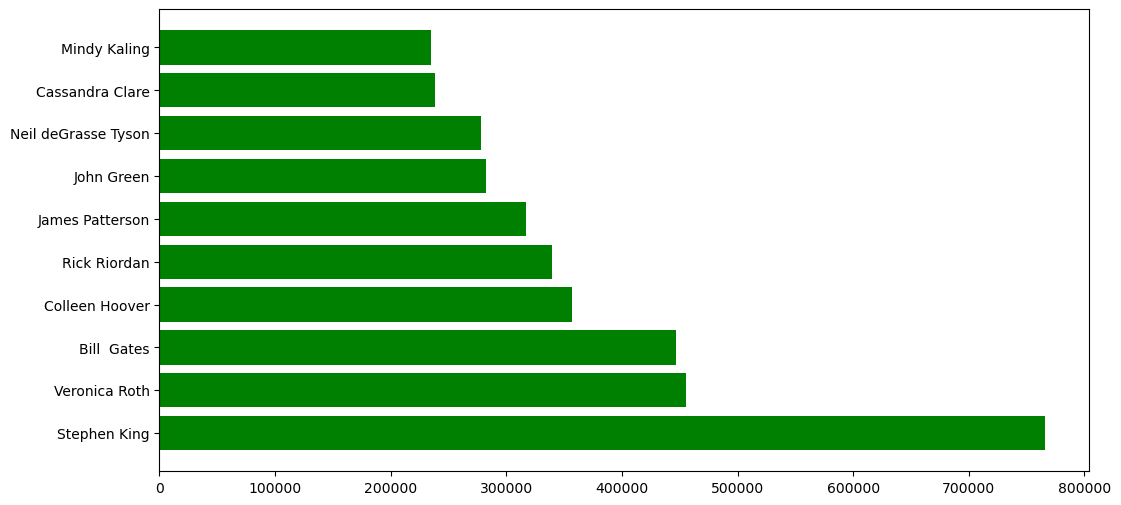

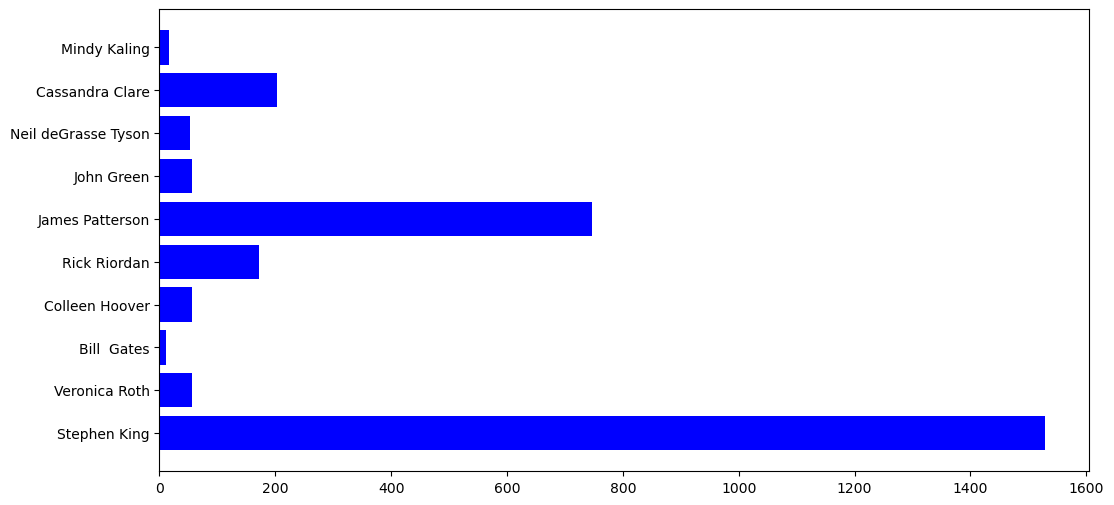

In [23]:
# count the actual number of books written by every author using the length of the list of his book ids.
authors["book_count"] = authors["work_ids"].apply(len)

# 10 most influential authors regarding their fan count
x = authors.nlargest(10, "fans_count")

# plot the data
plt.figure(figsize=(12, 6))
plt.barh(x["name"], x["fans_count"], color = 'green', label = 'Fan Count')
plt.figure(figsize=(12, 6))
plt.barh(x["name"], x["book_count"], color = 'blue', label = 'Book Count')
plt.show()

**Request 5.1b:** Plot the top 10 most influential authors regarding their fan count and number of books. Who is the most influential author?

In [64]:
# most influential author
m_inf = authors.nlargest(1, "fans_count")
print("The most influential author, having by far the largest fanbase is:", m_inf["name"].to_string(index = False))

The most influential author, having by far the largest fanbase is: Stephen King


**Request 5.2:** Have they published any series of books? If any, extract the longest series name among these authors.

In [63]:
# create a new dataframe containing only the books written by the top 10 authors
top_authors_books = books[books["author_id"].isin(list(x["id"]))]

# get the series authors by their "series position" to find who has written series, and use max position to determine their longest series' length.
author_series_lengths = top_authors_books.groupby(["author_id", "author_name"])["series_position"].max().reset_index()

# return the highest series position, thus the longest series author and name
author_series = top_authors_books.groupby(["author_id", "author_name", "series_name"])["series_position"].max().reset_index()
max_series = author_series[author_series["series_position"] == author_series["series_position"].max()]

print("Authors of series are:")
print(author_series_lengths["author_name"].to_string(index = False))

print("\nThe author of the longest series is:")
print(max_series["author_name"].to_string(index = False))
print("And the series is:")
print(max_series["series_name"].to_string(index = False))

Authors of series are:
       Stephen King
    James Patterson
Neil deGrasse Tyson
       Rick Riordan
        Bill  Gates
    Cassandra Clare
       Mindy Kaling
         John Green
      Veronica Roth
     Colleen Hoover

The author of the longest series is:
Rick Riordan
And the series is:
Percy Jackson and the Olympians


**Request 5.3:** How many of these authors have been published in different formats? Provide a meaningful chart on the distribution of the formats and comment on it.

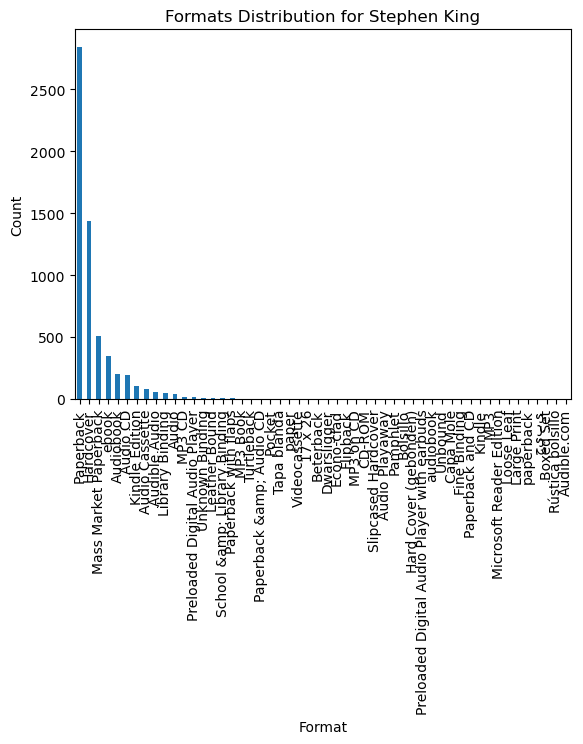

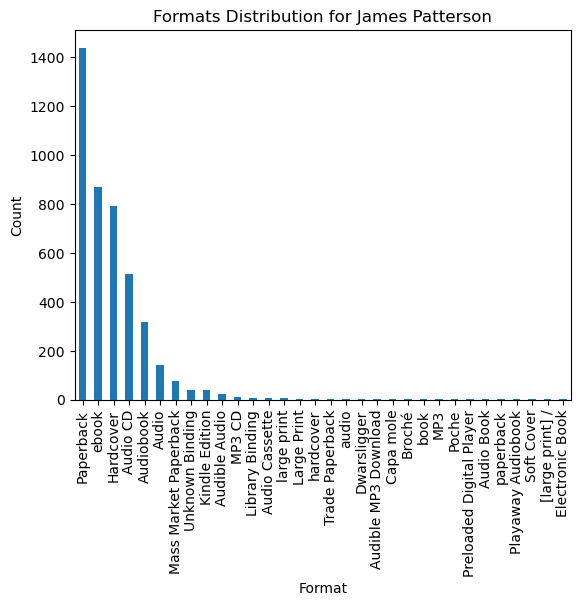

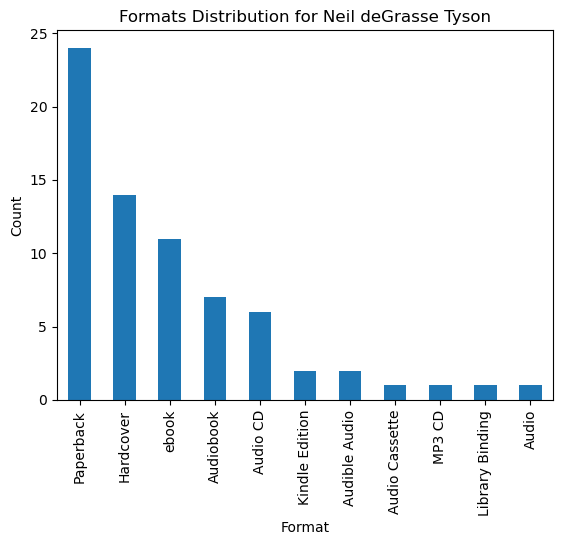

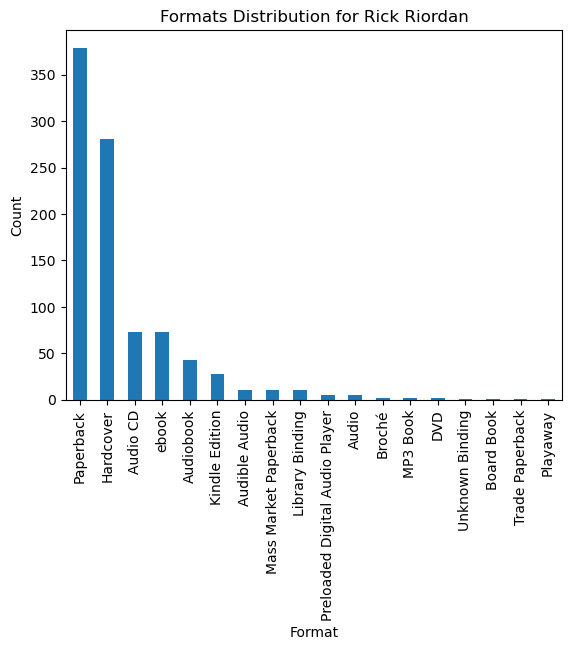

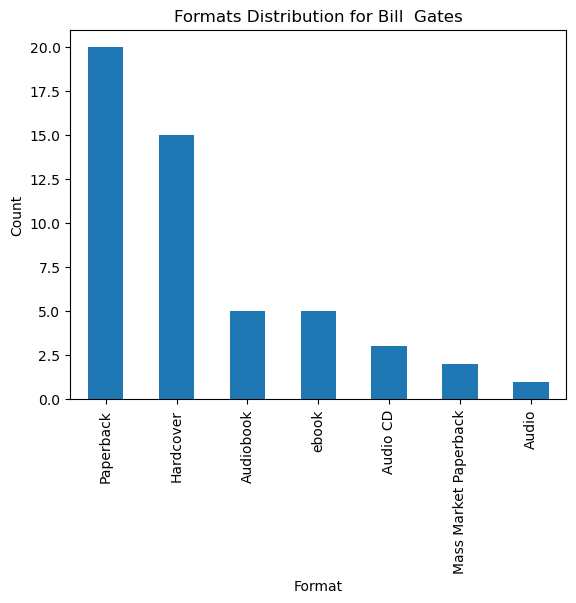

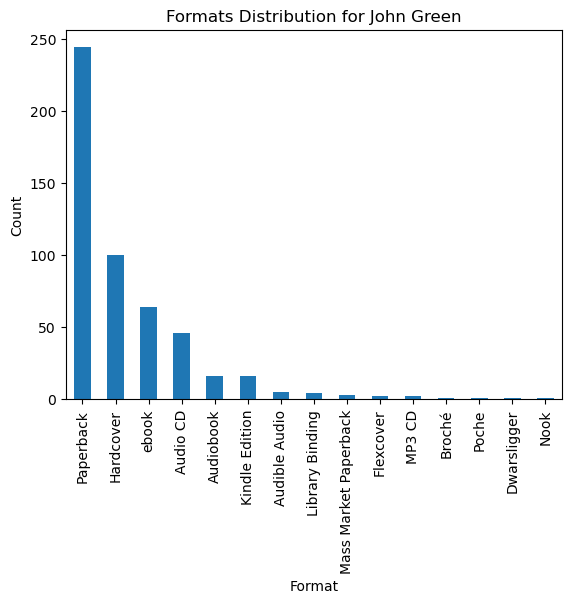

d:\Programs\Anaconda\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 21109 (\N{CJK UNIFIED IDEOGRAPH-5275}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
d:\Programs\Anaconda\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 20803 (\N{CJK UNIFIED IDEOGRAPH-5143}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
d:\Programs\Anaconda\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 25512 (\N{CJK UNIFIED IDEOGRAPH-63A8}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
d:\Programs\Anaconda\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 29702 (\N{CJK UNIFIED IDEOGRAPH-7406}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
d:\Programs\Anaconda\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 25991 (\N{CJK UNIFIED IDEOGRAPH-6587}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
d:\Program

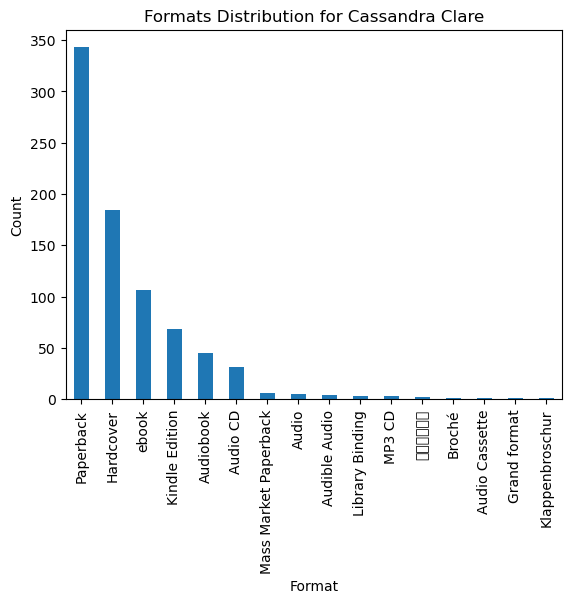

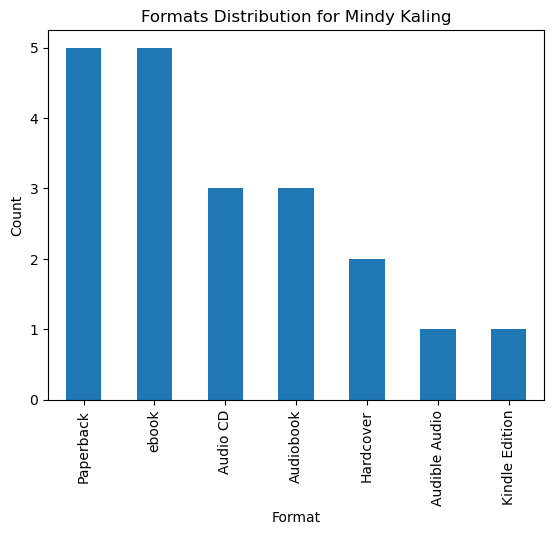

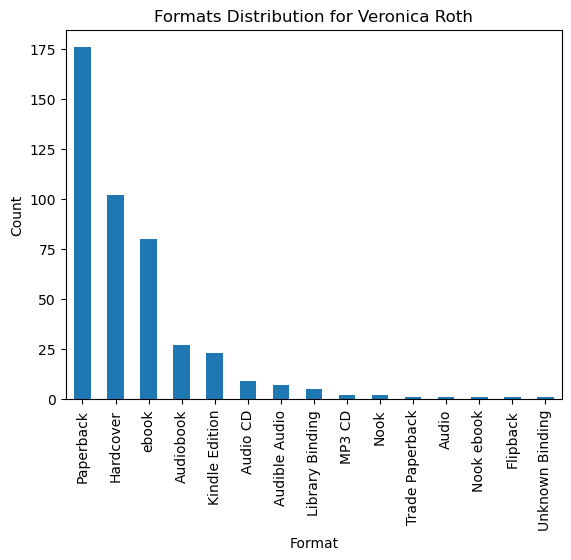

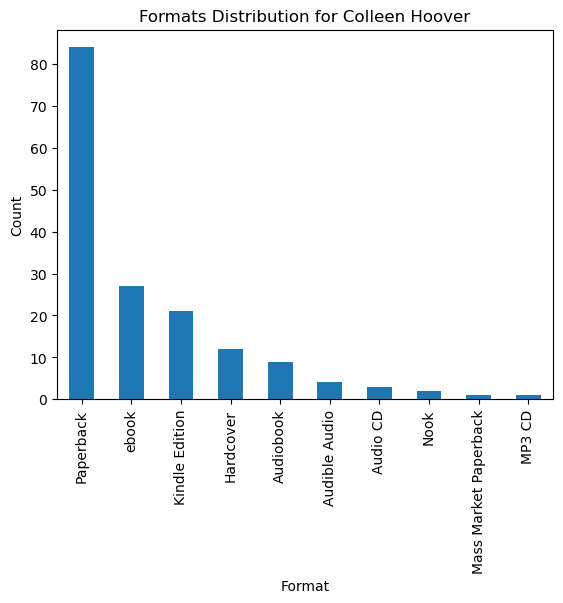

In [75]:
# to find the authors published in different formats from the top 10
authors_with_different_formats = top_authors_books[top_authors_books.duplicated(subset=["author_id"], keep = False)]
authors_with_different_formats = authors_with_different_formats[authors_with_different_formats["format"] != ""]

# to avoid name repetition
unique_author_ids = authors_with_different_formats["author_id"].unique()

# create a separate chart for each author with multiple formats
for author_id in unique_author_ids:
    author_data = authors_with_different_formats[authors_with_different_formats["author_id"] == author_id]
    author_name = author_data["author_name"].values[0]
    format_distribution = author_data["format"].value_counts()
    
    format_distribution.plot(kind='bar')
    plt.title(f"Formats Distribution for {author_name}")
    plt.xlabel("Format")
    plt.ylabel("Count")
    plt.show()

**Comments on the graphs above:** we can see that the books are mainly published in paperback and hardcover formats, whereas the "newer" digital formats are very few. This would be due to 3 main reasons: 
1- the age of most of the books written by these authors since audiobooks and ebook formats are relatively new.
2- even with more widely available digital formats now, these are authors of novels and readers who usually enjoy leisurely reading prefer the physical format of paper, rather than reading through a screen.
3- Once a book has been published in a digital format, there is no need to republish it using another editorial, since it is already on the internet, a more universal "bookstore".

**Request 5.4:** Provide information about the general response from readers (number of fans, average rating, number of reviews, etc.), divide the authors by gender, and comment about anything eventually related to “structural bias.” You may want to have a look at the following recommended readings:

- https://bhm.scholasticahq.com/article/38021
- https://priyanka-ddit.medium.com/how-to-deal-with-imbalanced-dataset-86de86c49
- https://compass.onlinelibrary.wiley.com/doi/10.1111/soc4.12962

You can even ask ChatGPT or any other LLM chatbot tool: try to formulate a prompt that provides helpful information about it. Put that information in your notebook and provide comments on what you found.

TODO

## [RQ6] For this question, consider the top 10 authors concerning the number of fans again.

    Provide the average time gap between two subsequent publications for a series of books and those not belonging to a series. What do you expect to see, and what is the actual answer to this question?
    For each of the authors, give a convenient plot showing how many books has the given author published UP TO a given year. Are these authors contemporary with each other? Can you notice a range of years where their production rate was higher?

**Request 6.1:** Provide the average time gap between two subsequent publications for a series of books and those not belonging to a series. What do you expect to see, and what is the actual answer to this question?

In [66]:
# step 1: transform the publication date entry to datetime format
top_authors_books["original_publication_date"] = pd.to_datetime(top_authors_books["original_publication_date"], format = 'mixed')

# calculate time gap between consecutive "original" publications and add it into a column for all books
top_authors_books["time_gap"] = top_authors_books.groupby(["author_id", "series_id"])["original_publication_date"].diff()

# calculate the average time gap for books in a series and not in a series, according to the new column created
average_time_gap_series = top_authors_books[top_authors_books["series_id"].notna()]["time_gap"].mean()
average_time_gap_non_series = top_authors_books[top_authors_books["series_id"].isna()]["time_gap"].mean()

# print(f"Average Time Gap for Books in a Series: {average_time_gap_series}")
# print(f"Average Time Gap for Books Not in a Series: {average_time_gap_non_series}")
print(top_authors_books)

OutOfBoundsDatetime: Out of bounds nanosecond timestamp: 10-01, at position 165

**What do we expect to see?** As expected the books that belong to a series have a more periodic and regular output from the authors(on average), and this logically makes sense following the idea that the author is breaking down a full story into separate books.
Books that do not belong to a series however do not have a well-defined average gap between them since they are independent works and do not follow any periodic output "expectation" from the public.

**Request 6.2:** For each of the authors, give a convenient plot showing how many books has the given author published UP TO a given year. Are these authors contemporary with each other? Can you notice a range of years where their production rate was higher?

In [67]:
# define a new column using the datetime format of the original publication date
top_authors_books['year'] = top_authors_books["original_publication_date"].dt.year
writers_counts = top_authors_books.groupby(['author_name', 'year']).size().reset_index(name='Count')

# plot the publication history for each author
writers = writers_counts['author_name'].unique()
for writer in writers:
    author_data = writers_counts[writers_counts['author_name'] == writer]
    plt.plot(author_data['year'], author_data['Count'], label=writer)

plt.title("Publication History of Authors")
plt.xlabel("Year")
plt.ylabel("Number of Books Published")
plt.legend()
plt.show()

AttributeError: Can only use .dt accessor with datetimelike values

## [RQ7] Estimating probabilities is a core skill for a data scientist: show us your best!

**Request 7.1:** Estimate the probability that a book has over 30% of the ratings above 4.

We can do that by counting how many books have 30% of the rating above 4 and dividing it by the total number of books.

In [ ]:
books[books["rating_dist"] == "5:-1|4:1|3:1|2:0|1:0|total:1"]
books[books["rating_dist"] == "5:0|4:0|3:3|2:-1|1:-1|total:1"]

In [76]:
def has_30p_above_four(rating_dist):
    pattern = r"5:([0-9]+)\|4:[0-9]+\|3:[0-9]+\|2:[0-9]+\|1:[0-9]+\|total:([0-9]+)"

    match = re.search(pattern, rating_dist)
    if int(match.group(1)) > 0.3 * int(match.group(2)):
        return True
    else:
        return False

df = books.drop(index = [6650514, 7011288]) # we remove this specific cases because the rating distribution is wrong
above_four = sum(df["rating_dist"].apply(has_30p_above_four))

result = above_four / df.shape[0]
print(result)

0.44710277400170106


**Request 7.2:** Estimate the probability that an author publishes a new book within two years from its last work.

TODO

**Request 7.3:** In the file list.json, you will find a peculiar list named "The Worst Books of All Time." Estimate the probability of a book being included in this list, knowing it has more than 700 pages.

We call the event "Book is in the worst books list" $A$ and the event "Book has more than 700 pages" $B$ and we use Bayes' formula:

$\mathbb{P}(\text{A | B}) = \frac{\mathbb{P}(\text{B | A}) \;\cdot\; \mathbb{P}(\text{A}) }{\mathbb{P}(\text{B})}$

* $\mathbb{P}(\text{A})$: the probability that a book is in the worst books list. Obtained by counting the entries in "The Worst Books of All Time" list and dividing it by the number of books in the dataset.
* $\mathbb{P}(\text{B})$: the probability that a book has more than 700 pages. Obtained by counting the entries with more than 700 pages and dividing it by the number of books in the dataset.
* $\mathbb{P}(\text{B | A})$: the probability of a book having more than 700 pages knowing that it is in the worst book list. Obtained by doing the second query over the books identified by first one.


Se i dataset sono in parte disgiunti che senso ha questa query?

In [77]:
df = books[books["num_pages"] != ""]

worst_books = pd.read_json(list_path, lines = True, nrows = 1)["books"][0]
worst_books = pd.DataFrame(worst_books)
worst_books["book_id"] = worst_books["book_id"].astype(int)
n_worst_books = worst_books.shape[0]
join = pd.merge(worst_books, df, left_on = "book_id", right_on = "id", how = "inner", suffixes = ["_w", "_b"])

pA = n_worst_books / df.shape[0]
pB = df[df["num_pages"].astype(int) > 700].shape[0] / (df.shape[0])
pBA = join[join["num_pages"].astype(int) > 700].shape[0] / (join.shape[0])
pAB = pBA * pA / pB

print("pA: ", pA)
print("pB: ", pB)
print("pBA: ", pBA)
print("pAB: ", pAB)

pA:  0.0018689977439556517
pB:  0.02809184760020993
pBA:  0.0383475684155482
pAB:  0.002551328053421057


**Request 7.4:** Are the events X=’Being Included in The Worst Books of All Time list’ and Y=’Having more than 700 pages’ independent? Explain how you have obtained your answer.

In [80]:
df["in_worst_book_list"] = df["id"].apply(lambda x: x in worst_books["book_id"].values)

C:\Users\Utente\AppData\Local\Temp\ipykernel_9124\943629732.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["in_worst_book_list"] = df["id"].apply(lambda x: x in worst_books["book_id"].values)


In [82]:
df["more_700_pages"] = df["num_pages"].apply(lambda x: x > 700)

C:\Users\Utente\AppData\Local\Temp\ipykernel_9124\4013637619.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["more_700_pages"] = df["num_pages"].apply(lambda x: x > 700)


In [85]:
print("Percentage of worst book over total: ", pA)
print("Percentage of book with more than 700 pages over total: ", pB)
print("Percentage of worst books in books with more than 700 pages", pAB)
print("Percentage of books with more than 700 in worst books", pBA)
print("Product of the single probabilities", pA * pB)
print("There is dipendence")

Percentage of worst book over total:  0.0018689977439556517
Percentage of book with more than 700 pages over total:  0.02809184760020993
Percentage of worst books in books with more than 700 pages 0.002551328053421057
Percentage of books with more than 700 in worst books 0.0383475684155482
Product of the single probabilities 5.250359978833835e-05
There is dipendence


## [RQ8] Charts, statistical tests, and analysis methods are splendid tools to illustrate your data-driven decisions to check whether a hypothesis is correct.

**Request 8.1:** Can you demonstrate that readers usually rate the longest books as the worst?

TODO

**Request 8.2:** Compare the average rate distribution for English and non-English books with a proper statistical procedure. What can you conclude about those two groups?

TODO

**Request 8.3:** About the two groups in the previous question, extract helpful statistics like mode, mean, median, and quartiles, explaining their role in a box plot.

TODO

**Request 8.4:** It seems reasonable to assume that authors with more fans should have more reviews, but maybe their fans are a bit lazy. Confirm or reject this with a convenient statistical test or a predictive model.

TODO

**Request 8.5:** Provide a short survey about helpful statistical tests in data analysis and mining: focus on hypothesis design and the difference between parametric and nonparametric tests, explaining the reasons behind the choice of one of these two tests.

# Bonus points

## 1

**Request 1.1:** Select one alternative library to Pandas (i.e., Dask, Polar, Vaex, Datatable, etc.), upload authors.json dataset, and filter authors with at least 100 reviews. Do the same using Pandas and compare performance in terms of milliseconds.

In [ ]:
# IN PANDAS

print("Measuring Pandas performance...")
%timeit authors[authors["text_reviews_count"] >= 100]

# IN DASK

authors_dask = dd.from_pandas(authors, npartitions = 1)

print("Measuring Dask performance...")
%timeit authors_dask[authors_dask["text_reviews_count"] >= 100].compute()

**Request 1.2:** Select one alternative library to Pandas (i.e., Dask, Polar, Vaex, Datatable, etc.), upload books.json, and join them with authors.json based on author_id. How many books don’t have a match for the author?

In [ ]:
join = pd.merge(books, authors, left_on = "author_id", right_on = "id", how = "left")[["id_y"]]
authorless_istances = join["id_y"].isna().sum()
print("Authorless istances: ", authorless_istances)

In [ ]:
join = dd.merge(dd.from_pandas(books, npartitions = 1), dd.from_pandas(authors, npartitions = 1), left_on = "author_id", right_on = "id", how = "left")
authorless_instances = join["id_y"].isna().sum().compute()
print("Authorless instances: ", authorless_instances)

In [ ]:
del worst_books

## 2 Every book should have a field named description, and any author should have a field named description. Choose one of the two and perform a text-mining analysis:

**Request 2.1:** If you choose to text-mine books.json ’ descriptions, try to find a way to group books in genres using whatever procedure you want, highlighting words that are triggers for these choices.

In [251]:
comedy_tags = ["humor", "comedy", "satire", "funny", "hilarious", "laughter", "light-hearted", "parody", "joke", "amusing", "whimsical", "lighthearted", "satirical", "witty", "comedic", "farce", "irony", "sarcasm", "slapstick"]
action_tags = ["adventure", "action", "suspense", "thriller", "excitement", "intense", "fast-paced", "hero", "villain", "combat", "chase", "explosion", "fighting", "action", "danger", "martial art", "high-octane", "adrenaline", "rescue", "mission"]
magic_tags = ["magic", "wizardry", "sorcery", "sorcerer", "witchcraft", "enchantment", "magician", "spellcasting", "conjuring", "curse", "alchemy", "fantasy", "mysticism", "occult", "supernatural", "sorcerer", "witch", "spell", "ritual", "arcane", "knowledge", "magical", "wizard"]
romance_tags = ["romance", "love", "relationship", "passion", "heartfelt", "emotional", "romantic", "couple", "affection", "intimacy", "desire", "chemistry", "flirting", "courtship", "kiss", "embrace", "lover", "seduction", "infatuation"]
mystery_tags = ["mystery", "detective", "suspense", "crime", "whodunit", "investigation", "thriller", "clues", "sleuth", "intrigue", "enigma", "puzzle", "murder", "suspicion", "conspiracy", "forensic", "solving", "sleuthing", "suspicion", "unraveling"]
sci_fi_tags = ["sci-fi", "planet", "science fiction", "space", "technology", "extraterrestrial", "future", "dystopian", "cyberpunk", "aliens", "time travel", "robots", "intergalactic", "virtual reality", "apocalypse", "AI", "nanotechnology", "post-apocalyptic"]
historical_tags = ["historical", "history", "period", "accuracy", "context", " era ", "research"]
horror_tags = ["horror", "supernatural", "scary", "terror", "suspense", "fear", "creepy", "haunting", "macabre", "dark", "spine-chilling", "nightmare", "ghost", "monster", "paranormal", "psychological", "halloween", "chill", "gore", "thriller"]
science_tags = ["science", "scientist", "research", "engineering", "discovery", "innovation", "technology", "scientific method", "experiment", "data", "analysis", "laboratory", "biology", "physic", "chemistry", "astronomy", "environment", "ecology", "genetic", "geology", "cosmology", "neuroscience"]
philosophy_tags = ["philosophy", "philosopher", "ethic", "morality", "metaphysic", "epistemology", "logic", "existentialism", "ontology", "aesthetic", "truth", "knowledge", "consciousness", "free will", "rationalism", "skepticism", "nihilism", "stoicism", "existentialism", "idealism"]
how_to_tags = ["how-to", "guide", "tutorial", "instruction", "step-by-step", "self-help", "manual", "handbook", "tips", "advice", "techniques", "DIY", "lessons", "methods", "strategies", "procedures", "skills", "training", "tactics", "expertise"]
manga_tags = ["manga", "shonen", "shojo", "seinen", "josei", "slice of life", "isekai"]
comics_tags = ["comic", "graphic novel", "superhero", "webcomic", "cartoon", "comic strip", "comic book", "sequential art", "indie comic", "humor comic"]
spirituality_tags = ["spirituality", "mindfulness", "meditation", "spiritual", "enlightenment", "inner peace", "consciousness", "self-discovery", "yoga", "soul"]
religion_tags = ["religion", "faith", "atheism", "belief", "theology", "religious", "monotheism", "polytheism", "scripture", "worship", "prayer", "religious text", "religious practices", "theological debate", "interfaith", "sacred", "ritual", "divinity", "pope", "bible"]
cook_tags = ["cooking", "culinary", "recipes", "cookbook", "gastronomy", "food preparation", "culinary arts", "chef", "cuisine", "kitchen", "cooking techniques", "baking", "gourmet", "foodie", "tasty", "cultural cuisine", "food science", "culinary history", "meal planning", "cooking tips"]
classic_tags = ["classic", "ancient", "timeless", "vintage", "nostalgic", "iconic", "enduring", "ageless", "traditional", "time-honored", "heritage", "historic", "canonical", "old-fashioned", "antique", "retro", "time-tested", "enduring", "beloved", "literary", "literature"]
economy_tags = ["economy", "economic", "entrepreneur", "finance", "business", "trend", "market", "investment", "wealth", "fiscal", "monetary", "budgeting", "capitalism", "consumer", "taxation", "entrepreneurship", "financial", "trade", "economic crisis"]


tags_lists = [comedy_tags, magic_tags, action_tags, romance_tags, mystery_tags, sci_fi_tags, historical_tags, horror_tags, science_tags, philosophy_tags, how_to_tags, manga_tags, comics_tags, spirituality_tags, religion_tags, cook_tags, classic_tags, economy_tags]

n = 87
descriptions = pd.read_json(books_path, lines = True, nrows = 10000)[["description", "title"]]
description = descriptions["description"][n]
title = descriptions["title"][n]

tag_scores = dict()
for tag_list in tags_lists:
    tag_name = tag_list[0]
    score = 0
    for word in tag_list:
        score += description.lower().count(word)
        if description.lower().count(word) != 0:
            print(word)

    tag_scores[tag_name] = score
    
print("Book title:", title)
tag_scores = sorted(tag_scores.items(), key=lambda x: x[1], reverse = True)
for key, value in tag_scores[:3]:
    if value != 0:
        print(f"Tag: '{key}', Corrispondences found: '{value}'")

print(description)

mysticism
adventure
planet
science fiction
science
environment
ancient
Book title: Dune (Dune Chronicles, #1)
Tag: 'sci-fi', Corrispondences found: '2'
Tag: 'science', Corrispondences found: '2'
Tag: 'magic', Corrispondences found: '1'
Here is the novel that will be forever considered a triumph of the imagination. Set on the desert planet Arrakis, <i>Dune</i> is the story of the boy Paul Atreides, who would become the mysterious man known as Muad'Dib. He would avenge the traitorous plot against his noble family—and would bring to fruition humankind's most ancient and unattainable dream. <br /><br />A stunning blend of adventure and mysticism, environmentalism and politics, <i>Dune</i> won the first Nebula Award, shared the Hugo Award, and formed the basis of what is undoubtedly the grandest epic in science fiction.


**Request 2.2:** If you choose to text-mine authors.json’ about-field, try to find a way to group authors in genres using whatever procedure you want, highlighting words that are triggers for these choices.

In [253]:
n = 175
descriptions = pd.read_json(authors_path, lines = True, nrows = 10000)[["about", "name"]]
description = descriptions["about"][n]
name = descriptions["name"][n]

tag_scores = dict()
for tag_list in tags_lists:
    tag_name = tag_list[0]
    score = 0
    for word in tag_list:
        score += description.lower().count(word)
        if description.lower().count(word) != 0:
            print(word)

    tag_scores[tag_name] = score
    
print("Author name: ", name)
tag_scores = sorted(tag_scores.items(), key=lambda x: x[1], reverse = True)
for key, value in tag_scores[:3]:
    if value != 0:
        print(f"Tag: '{key}', Corrispondences found: '{value}'")

print(description)

literary
literature
Author name:  Jorge Luis Borges
Tag: 'classic', Corrispondences found: '2'
Jorge Francisco Isidoro Luis Borges Acevedo, usually referred to as Jorge Luis Borges (Spanish pronunciation: [xoɾxe lwis boɾxes]), was an Argentine writer and poet born in Buenos Aires. In 1914, his family moved to Switzerland where he attended school and traveled to Spain. On his return to Argentina in 1921, Borges began publishing his poems and essays in Surrealist literary journals. He also worked as a librarian and public lecturer. Borges was fluent in several languages. He was a target of political persecution during the Peron regime, and supported the military juntas that overthrew it.<br /><br />Due to a hereditary condition, Borges became blind in his late fifties. In 1955, he was appointed director of the National Public Library (Biblioteca Nacional) and professor of Literature at the University of Buenos Aires. In 1961, he came to international attention when he received the first 

**Request 2.3:** If you feel comfortable and did both tasks, analyze the matching of the two procedures. You grouped books and authors in genres. Do these two procedures show correspondence?

# Command Line Question (CLQ)

Using the command line is a feature that Data Scientists must master. It is relevant since the operations there require less memory to use in comparison to other interfaces. It also uses less CPU processing time than other interfaces. In addition, it can be faster and more efficient and handle repetitive tasks quickly.

Note: To answer the question in this section, you must strictly use command line tools. We will reject any other method of response.

Looking through the files, you can find series.json, which contains a list of book series. In each series's 'works' field, you'll find a list of books that are part of that series. Report the title of the top 5 series with the highest total 'books_count' among all of their associated books using command line tools.

1. Write a script to provide this report. Put your script in a shell script file with the appropriate extension, then run it from the command line. The file should be called commandline_original.[put_the_proper extension]

2. Try interacting with ChatGPT or any other LLM chatbot tool to implement a more robust script implementation. Your final script should be at most three lines. Put your script in a shell script file with the appropriate extension, then run it from the command line. The file should be called commandline_LLM.[put_the_proper_ extension]. Add in your homework how you employed the LLM chatbot tools, validate if it is correct, and explain how you check its correctness.

The expected result is as follows:

| id    | title                                | total_books_count |
|-------|--------------------------------------|-------------------|
| 302380| Extraordinary Voyages                | 20138             |
| 94209 | Alice's Adventures in Wonderland     | 14280             |
| 311348| Kolekcja Arcydzieł Literatury Światowe| 13774             |
| 41459 | Oz                                   | 11519             |
| 51138 | Hercule Poirot                       | 11305             |

**Request 1:**

The shell script file *commandline_original.sh* is implemented as requested and the output correspond to what it's expected, the only difference we find it's the transformation of special characters like 'Ś' in 'Światowe' to their unicode counterpart, as '\u015'. Comment on the code is inside the file itself but we briefly describe the code here: for each line of the json file we extract 'id' and 'title' of the series and than the whole "works" subsection using Regexs. From the "works" subsection we search every field 'work_counts', sum the value, store it in an accumulator and append everything in a list. After having gone through every line of the json file we sort the list using only the total work counts field and using a for cycle print the first five results following the format of the table shown.

**Request 2:**

We tried to use ChatGPT 3.5 to implement a more robust script implementation that is also at most three lines. This is the prompt sent:

```
You have to write a more robust implementation of the given bash code. Your implementation must be at most three lines long. You can't use jq.
[original sh code here]
```

We explicitely said not to use jq to avoid using external libraries. The result is stored in *commandline_LLM.sh* and it doesn't work. We can immediately see it from the different output and the fact that in the source code it's never mentioned the field "books_count". We also tried to use alternative LLMs chatbots like Bing with similar results. Removing the costraint of using only three lines the results become correct but also extremely similar to the original code. Meanwhile giving only the text of the question does not bring positive results.

# AWS Question (AWSQ)

AWS offers access to many cloud-based tools and services that simplify data processing, storage, and analysis. Thanks to AWS's scalable and affordable solutions, data scientists can work effectively with large datasets and carry out advanced analytics. A data scientist must, therefore, perform the essential task of learning how to use AWS. To complete a straightforward data analysis task in this question, you must set up an environment on Amazon Web Services.

In this question, you are asked to provide the most commonly used tags for book lists. Going through the list.json file, you'll notice that each list has a list of tags attached, and we want to see what are the most popular tags across all of the lists. Please report the top 5 most frequently used tags and the number of times they appear in the lists.

You have to follow the following (recommended) steps:

* Download the list.json file to your local system.
* Write a Python script that generates the report and the system's time to generate it.
* Set up an EC2 instance on your AWS account and upload the list.json file together with your script to the instance
* Compare the running times of your script on your local system and the EC2 instances.

**Important note:** Please run the same script on both your local system and your EC2 instance to compare the results. e.g., * keep the parameters the same if you are processing the data by loading it partially and aggregating the results. Comment about the differences you find.

Please provide a report as follows:

* The information about the config of the EC2 instance
* The command used to connect to the EC2
* The commands used to upload the files and run the script on the EC2 instance through your local system
* A table containing the most popular tags and their number of usage
* A table containing the running time of the script on your local system and EC2 instance

The following is the expected outcome for the most popular tags:

|     Tag            |   # Usage   |
|--------------------|------------|
| romance            |     6001    |
| fiction            |     5291    |
| young-adult        |     5016    |
| fantasy            |     3666    |
| science-fiction    |     2779    |

TODO

# Algorithmic Question (AQ)

Assume you are working as a librarian at a public library in Rome. Some new books have arrived, and you are in charge of putting them on a shelf. Your supervisor will give you some instructions, and you will follow his. Each book has a unique ID, and your boss's instructions can be of the following types:

* L N - place the book with ID = N on the shelf to the left of the leftmost existing book
* R N - place the book with ID = N on the shelf to the right of the rightmost existing book
* ? N - Calculate the minimum number of books you must pop from the left or right to have the book with ID = N as the leftmost or rightmost book on the shelf.

You must follow your boss's instructions and report the answers to type 3 instructions to him. He guarantees that if he has a type 3 instruction for a book with a specific ID, the book has already been placed on the shelf.

Remember that once you've answered a type 3 instruction, the order of the books does not change.

**Input:**

The first line contains a single number, n, representing the number of your boss's instructions. The ith instruction the boss gives can be found at each of the following n lines.

**Output:**

Print your boss's type 3 instructions in the order they appear in the input.

**Examples:**

Input 1
```
L 75
R 20
R 30
L 11
? 75
L 12
L 15
? 20
```

Output 1
```
1
1
```

Input 2
```
R 1
L 2
L 3
L 4
? 3
R 5
R 6
L 7
L 8
? 4
L 9
R 10
R 11
L 12
L 13
? 11
? 3
```

Output 2:
```
1
2
0
6
```

**Request 1:** Implement a code to answer the problem above.

In [ ]:
def algorithmic_question(input_string):
    input_list = input_string.split("\n")
    n_commands = int(input_list.pop(0))

    shelf = []
    output = []
    for i in range(n_commands):
        command = input_list[i].split(" ")
        if command[0] == "L":
            shelf = [command[1]] + shelf
        elif command[0] == "R":
            shelf = shelf + [command[1]]
        elif command[0] == "?":
            index = shelf.index(command[1])
            result = min(index, (len(shelf) - 1) - index)
            output.append(result)

    print(*output, sep = "\n")
    return
 
input1 = "8\nL 75\nR 20\nR 30\nL 11\n? 75\nL 12\nL 15\n? 20\n"
print("Test1:")
algorithmic_question(input1)


input2 = "17\nR 1\nL 2\nL 3\nL 4\n? 3\nR 5\nR 6\nL 7\nL 8\n? 4\nL 9\nR 10\nR 11\nL 12\nL 13\n? 11\n? 3\n"
print("\nTest2:")
algorithmic_question(input2)

**Request 2:** Ask ChatGPT or any other LLM chatbot tool to check your code's time complexity (the Big O notation). Do you believe this is correct? How can you double-check it? Elaborate about your answer.

We asked Chat GPT 3.5 for the code's time complexity using the following prompt:

```
You are given a python code for a function and asked to find its time complexity in the Big-O notation. The input for the function is a string where the first line contains a single number representing the number of instructions. The i-th instruction can be found at each of the following n lines.

[python function presented above]
```
\
The answer provided is:

```
To determine the time complexity of the given `algorithmic_question` function in Big-O notation, we need to analyze the time complexity of each part of the code separately and then combine them.

1. Splitting the input string: 
   `input_list = input_string.split("\n")`
   This operation splits the input string into a list of lines, which takes O(n) time, where n is the number of characters in the input string.

2. Extracting the number of commands:
   `n_commands = int(input_list.pop(0))`
   `pop(0)` operation on a list has a time complexity of O(n), where n is the number of elements in the list.

3. Loop over n_commands (for loop):
   The loop iterates n_commands times, and for each iteration, the following operations are performed:
   
   a. Splitting the command:
      `command = input_list[i].split(" ")`
      Splitting a string into a list has a time complexity of O(m), where m is the number of characters in the string.

   b. Checking the command type (if-elif statements):
      This is a constant-time operation as it involves simple string comparisons.

   c. Performing actions based on the command:
      - In the case of "L" and "R" commands, the list `shelf` is modified by adding or removing an element. Appending or inserting an element into a list takes O(1) time on average.
      - In the case of the "?" command, it searches for an item in the list using the `index` method. In the worst case, this can take O(n) time if the item is at the end of the list.
      - Appending to the `output` list takes O(1) time.

4. Printing the output:
   `print(*output, sep = "\n")`
   Printing the output takes O(m) time, where m is the total number of characters in the output.

In the worst-case scenario, the most time-consuming operation is searching for an item in the `shelf` list using the `index` method, which has a time complexity of O(n). Therefore, the overall time complexity of the function can be approximated as O(n_commands * n), where n_commands is the number of commands, and n is the maximum number of elements in the `shelf` list during the execution of the function.

So, in Big-O notation, the time complexity of the `algorithmic_question` function is O(n * n_commands), where n is the maximum number of elements in the `shelf` list, and n_commands is the number of commands.
```

\
Chat GPT answers, explaining the steps of its reasoning and concluding that the time complexity is O(n * n_commands). Even if that is correct, Chat GPT hasn't grasped that n = n_commands, so we try the same prompt adding a line that makes it more explicit:

```
You are given a python code for a function and asked to find its time complexity in the Big-O notation. The input for the function is a string where the first line contains a single number representing the number of instructions. The i-th instruction can be found at each of the following n lines. This means that n_commands and n are the same number.

[python function presented above]
```
\
This time the answer of Chat GPT is:

```
To find the time complexity of the algorithmic_question function in Big-O notation, let's analyze the key operations within the function and count the number of times each operation is executed. We'll break it down step by step:

Splitting the input string:

The input_string.split("\n") operation takes O(n) time, where n is the number of lines in the input string.
Parsing the number of instructions:

Converting the first element of input_list to an integer (int(input_list.pop(0))) takes O(1) time.
Looping through the instructions:

The loop runs for n_commands iterations, where n_commands is the number of instructions. This loop has a time complexity of O(n_commands).
Inside the loop:

Splitting the current command: command = input_list[i].split(" "). This operation takes O(1) time since the number of words in a command is constant.

Checking the command type with if statements: These are O(1) operations since they involve simple string comparisons.

Appending to or prepending to the shelf list: These operations involve list manipulation and have a time complexity of O(k), where k is the number of elements in the list. In the worst case, k can be n (number of instructions).

Searching for an element in the shelf list: The shelf.index(command[1]) operation takes O(k) time in the worst case, where k is the number of elements in the list.

Appending to the output list: This is an O(1) operation.

Printing the output list:

The print(*output, sep="\n") operation takes O(k) time, where k is the number of elements in the output list.
Now, let's consider the overall time complexity:

The most significant part of the time complexity is the loop that runs for n_commands iterations.
Within each iteration of the loop, there are O(k) operations, where k is the maximum number of elements in the shelf and output lists.
Therefore, the overall time complexity of the algorithmic_question function can be expressed as O(n_commands * k), where n_commands is the number of instructions and k is the maximum number of elements in the shelf and output lists. In the worst case, k can be n (number of instructions), so the time complexity is O(n_commands * n), or simply O(n^2), where n is the number of instructions.

So, the time complexity of this function is O(n^2).
```

\
We belive this is correct and we can double-checking it by doing the calculations ourselves. The dominant operation of the algorithm is: "`index = shelf.index(command[1])`". This line search the index corresponding to a certain element in a python list and for doing so it has to check element by element if the element in the list is the current one. The worst-case scenario for this operation is when the element is found as the last checked element, making the operation runs at O(m) time with m length of the list.

This operation is inside a loop that runs n times, with n the number of operations in the input. We can imagine the worst-case scenario as n/2 "L" or "R" insertion operations and then n/2 "?" search operations, which both are O(n). This means that we will have  n elements in the array and doing the search operations n times, resulting in a total time complexity of O(n^2).

**Request 3:** Is the algorithm proposed in (1.) the optimal one to produce the required output? If not, can you suggest a better algorithm to perform the same task?

TODO